In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleSegmentationModel(nn.Module):
    def __init__(self):
        super(SimpleSegmentationModel, self).__init__()
        # Encoder
        self.enc_conv1a = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)
        
        # Decoder
        self.dec_conv1a = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv1b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_conv2a = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # Encoder
        x1 = F.relu(self.enc_bn1(self.enc_conv1a(x)))
        x1 = F.relu(self.enc_bn1(self.enc_conv1b(x1)))
        x1p = self.pool(x1)
        x2 = F.relu(self.enc_bn2(self.enc_conv2a(x1p)))
        x2 = F.relu(self.enc_bn2(self.enc_conv2b(x2)))
        x2p = self.pool(x2)
        x3 = F.relu(self.enc_bn3(self.enc_conv3a(x2p)))
        x3 = F.relu(self.enc_bn3(self.enc_conv3b(x3)))
        
        # Decoder
        x3u = self.upsample(x3)
        x2d = F.relu(self.dec_bn1(self.dec_conv1a(x3u)))
        x2d = F.relu(self.dec_bn1(self.dec_conv1b(x2d)))
        x1u = self.upsample(x2d)
        x1d = F.relu(self.dec_bn2(self.dec_conv2a(x1u)))
        x1d = F.relu(self.dec_bn2(self.dec_conv2b(x1d)))
        x_out = self.dec_conv3(x1d)
        
        # Output
        x_out = torch.sigmoid(x_out)  # Sigmoid activation to output probabilities
        return x_out

In [2]:
import os
import torch


device = torch.device('cpu')

model = SimpleSegmentationModel()

cwd = os.getcwd()

state_dictionary = torch.load(f'{cwd}/cnn.pth')

model.load_state_dict(state_dictionary)
model.eval()

model.to(device)

SimpleSegmentationModel(
  (enc_conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_conv1a): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_conv1b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_bn1): BatchNorm2d(128

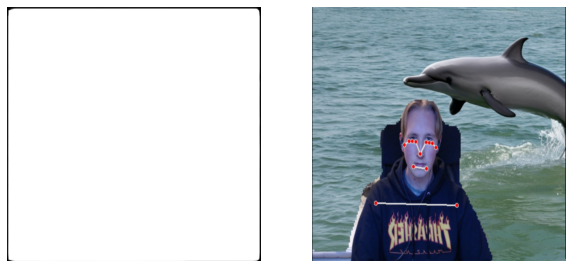

In [3]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def plot(mask, image):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    mask_np = mask.squeeze().cpu().detach().numpy()
    image_np = image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    
    axs[0].imshow(mask_np, cmap='gray')
    axs[0].axis('off')

    axs[1].imshow(image_np)
    axs[1].axis('off')

    plt.show()

image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image_tensor = image_transform(image).float()
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor.to(device)
    return image_tensor

image = load_image(f'{cwd}/test.png')

output = model(image)

plot(output, image)

